In [55]:
import pandas as pd
import swifter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 5]


In [56]:
df = pd.read_csv("./Data/Part 1 - Kickstarter.csv")

Exercise 1: Information gain with categories
In this first exercise, we focus on how to compute information gain (see book for definition, formulas,
etc.). Go to sheet “Ex1” in the Excel file.
As a first exercise, we want to know “What is the information gain of creating two segments of
crowdfunding campaigns based on their country (US vs non-US) regarding campaign success?”
In order to do so, compute the following values for the first table:
- Number of campaigns that are in each segment all/US/non-US (column C)
- Fraction of campaigns that are in each segment all/US/non-US (column D)
- Number of all/US/non-US campaigns that are successful (column E)
- Fraction of all/US/non-US campaigns that are successful (column F)
- Entropy score of each segment based upon fraction successful/failed (column G)
- The information gain (column H)
Hint: to compute entropy with log values using a base of two, use “=LOG(VALUE, 2)” in Excel. If you
prefer a manual calculator, it varies by brand and type.

In [57]:
df['us_campaigns'] = df['country'].apply(lambda x: "US" if x == 'US' else "non-US")

us_campaigns = df.us_campaigns.value_counts()
total_campaigns = len(df)
share_us = us_campaigns['US'] / total_campaigns
share_non_us = us_campaigns['non-US'] / total_campaigns

print(f"Total number of campaigns: {total_campaigns}")
print(f"Number of US campaigns: {us_campaigns['US']}, {share_us}%")
print(f"Number of non-US campaigns: {us_campaigns['non-US']}, {share_non_us}%")


Total number of campaigns: 331465
Number of US campaigns: 261360, 0.7884995399212587%
Number of non-US campaigns: 70105, 0.21150046007874135%


In [58]:
total_successes = df.outcome.value_counts()['successful']
prob_success = total_successes / total_campaigns
prob_failure = 1 - prob_success

geo_success = df.groupby('outcome')['us_campaigns'].value_counts()['successful']
prob_success_us = geo_success['US'] / us_campaigns['US']
prob_success_non_us = geo_success['non-US'] / us_campaigns['non-US']

print(f"Total number of successful campaigns: {total_successes}, {np.round(prob_success, 3)}%")
print(f"Number of successful US campaigns: {geo_success['US']}, {np.round(prob_success_us, 2)}%")
print(f"Number of successful non-US campaigns: {geo_success['non-US']}, {np.round(prob_success_non_us, 2)}%")

Total number of successful campaigns: 133851, 0.404%
Number of successful US campaigns: 109299, 0.42%
Number of successful non-US campaigns: 24552, 0.35%


In [59]:
entropy_parent = -prob_success * np.log2(prob_success) - prob_failure * np.log2(prob_failure)

entropy_us = -prob_success_us * np.log2(prob_success_us) - (1-prob_success_us) * np.log2(1-prob_success_us)
entropy_non_us = -prob_success_non_us * np.log2(prob_success_non_us) - (1-prob_success_non_us) * np.log2(1-prob_success_non_us)
info_gain = entropy_parent - (share_us * entropy_us + share_non_us * entropy_non_us)

print(f"Parent entropy: {entropy_parent}")
print(f"US entropy: {entropy_us}")
print(f"Non-US entropy: {entropy_non_us}")
print(f"Information gain: {np.round(info_gain, 5)}")

Parent entropy: 0.9731393096004877
US entropy: 0.9806029093573498
Non-US entropy: 0.9342621788423611
Information gain: 0.00234


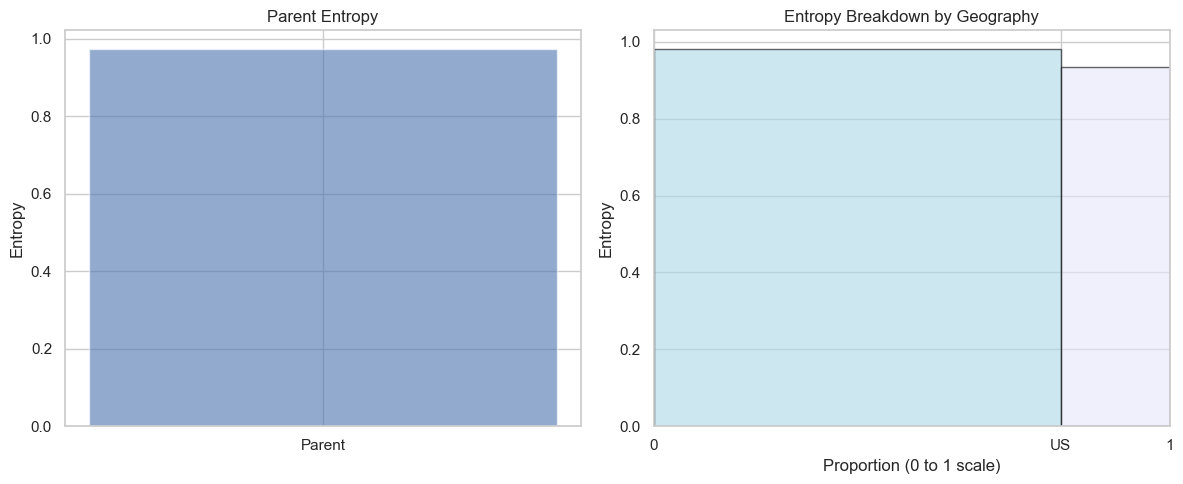

In [60]:
# Data
labels = ['US', 'Non-US']
entropy_values = [entropy_us, entropy_non_us]
proportions = [share_us, share_non_us]

# Define x positions to match proportional breakdown
x_positions = [0, share_us]  # US starts at 0, Non-US starts at share_us

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Parent Entropy
axes[0].bar(['Parent'], [entropy_parent], alpha=0.6, width=0.5)
axes[0].set_title('Parent Entropy')
axes[0].set_ylabel('Entropy')
axes[0].grid(True)

# Plot 2: Breakdown of Parent Entropy
axes[1].bar(x_positions, entropy_values, width=proportions, color=['lightblue', 'lavender'], alpha=0.6, align='edge', edgecolor='black')
axes[1].set_title('Entropy Breakdown by Geography')
axes[1].set_ylabel('Entropy')
axes[1].set_xlabel('Proportion (0 to 1 scale)')
axes[1].set_xlim(0, 1)
axes[1].set_xticks([0, share_us, 1])  # Marks start, US end, and Non-US end
axes[1].set_xticklabels(['0', 'US', '1'])
axes[1].grid(True)

# Improve layout
plt.tight_layout()
plt.show()

Information gain can also be computed by splitting a sample into multiple segments. Therefore we
want to know “What is the information gain of creating four segments of campaigns based on their
countries, namely US, Canada, Great Britain, and others, regarding campaign success?”
Use the second table on sheet “Ex1”, compute the information gain based on splitting it into four
segments (US, Canada, Great Britain, and Other).

In [61]:
df['country_groups'] = df['country'].map({'US': 'US', 'CA': 'CA', 'GB': 'GB'}).fillna('Other')

In [62]:
df.groupby('outcome')['country_groups'].value_counts()['successful']

country_groups
US       109299
GB        12067
Other      8351
CA         4134
Name: count, dtype: int64

In [63]:
# Get total counts per country
total_counts = df['country_groups'].value_counts()

# Get successful counts per country 
success_counts = df[df['outcome']=='successful']['country_groups'].value_counts()

# Calculate success rates and store both absolute and relative numbers
groups_sucesses = {
    country: (success_count, success_count/total_counts[country])
    for country, success_count in success_counts.items()
}
    

groups_sucesses =pd.DataFrame.from_dict(groups_sucesses, orient='index', columns=['success_num', 'success_prob'])
groups_sucesses['share_of_total'] = total_counts[groups_sucesses.index] / total_counts.sum()
groups_sucesses

,success_num,success_prob,share_of_total
US,109299,0.418193,0.788500
GB,12067,0.409690,0.088860
Other,8351,0.295287,0.085321
CA,4134,0.334196,0.037319


In [64]:
print(f"Parent entropy: {entropy_parent}")

groups_sucesses['entropy'] = (-groups_sucesses['success_prob'] * np.log2(groups_sucesses['success_prob']) 
                              - (1-groups_sucesses['success_prob']) * np.log2(1-groups_sucesses['success_prob']))

groups_sucesses

Parent entropy: 0.9731393096004877


,success_num,success_prob,share_of_total,entropy
US,109299,0.418193,0.788500,0.980603
GB,12067,0.409690,0.088860,0.976337
Other,8351,0.295287,0.085321,0.875453
CA,4134,0.334196,0.037319,0.919156


In [65]:
groups_weighted_entropy = 0

for country in groups_sucesses.index:
    groups_weighted_entropy += groups_sucesses['share_of_total'][country] * groups_sucesses['entropy'][country]
    
info_gain = entropy_parent - groups_weighted_entropy
print(f"Information gain: {info_gain}")

Information gain: 0.004180149552692414


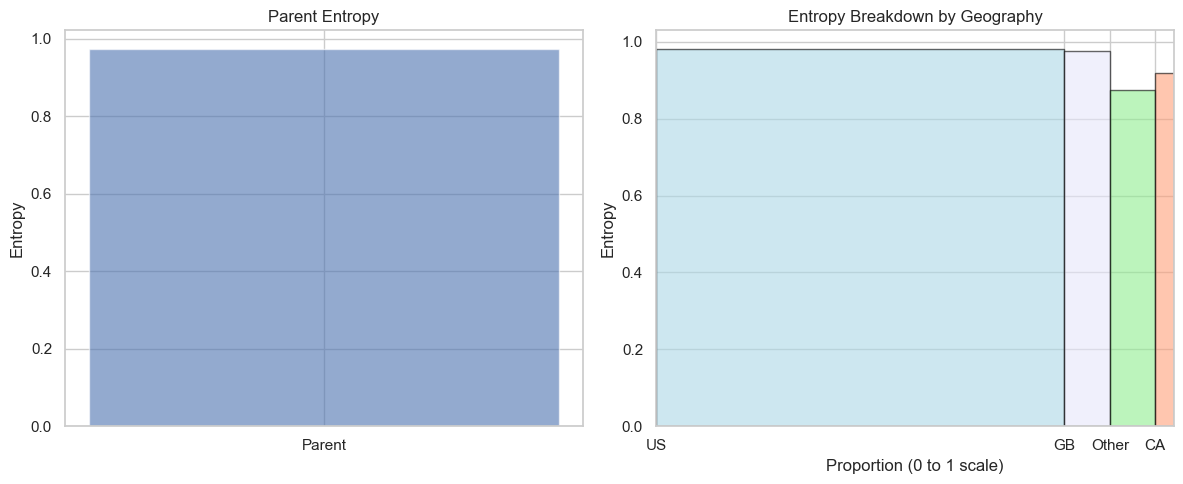

In [66]:
labels = groups_sucesses.index
entropy_values = groups_sucesses['entropy']
proportions = groups_sucesses['share_of_total']

# Define x positions to match proportional breakdown
x_positions = [0] + list(groups_sucesses['share_of_total'].cumsum())
# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Parent Entropy
axes[0].bar(['Parent'], [entropy_parent], alpha=0.6, width=0.5)
axes[0].set_title('Parent Entropy')
axes[0].set_ylabel('Entropy')
axes[0].grid(True)

# Plot 2: Breakdown of Parent Entropy
colors = ['lightblue', 'lavender', 'lightgreen', 'lightsalmon']
axes[1].bar(x_positions[:-1], entropy_values, width=proportions, color=colors, alpha=0.6, align='edge', edgecolor='black')
axes[1].set_title('Entropy Breakdown by Geography')
axes[1].set_ylabel('Entropy')
axes[1].set_xlabel('Proportion (0 to 1 scale)')
axes[1].set_xlim(0, 1)
axes[1].set_xticks(np.cumsum([0] + list(proportions[:-1])))  # Mark boundaries between countries
axes[1].set_xticklabels(labels)
axes[1].grid(True)

# Improve layout
plt.tight_layout()
plt.show()



Exercise 2: Gaining insights ** feel free to skip this if it takes too long (see the additional
dataset on canvas)
The current dataset contains the raw information about crowdfunding campaigns. Often, we can get
more useful variables about of these raw details. Currently missing key variables are:
- Outcome dummy (a zero/one variable for failure/successful outcome)
- Duration of a campaign (difference between start date and end date rounded up in full days)
- Average pledge (average size of a backer’s pledge, using ‘usd_pledged_real’ and ‘backers’,
rounded to full USD, and zero in case of errors)
- Success in same main category (percentage of projects successful in the same main category)
- Success in same sub-category (percentage of projects successful in the same sub-category)
Create the first variable in sheet “Data” in column P. You can use a function or do this manually.
Compute the next two variables in columns Q and R, using ‘=ROUNDUP’ and ‘=ROUND’ respectively.
Compute the last two variables using ‘=COUNTIFS’, ‘=AVERAGEIFS’ and/or ‘=SUMIFS’. As this takes
very long, we have already done this from row 2,001 onward. You only need to do this for the first
2,000 observations. If you did this correctly, the full column average of these variables are 34, 66,
40.38%, and 40.38%, for columns Q, R, S, and T, respectively.

In [67]:
df = pd.concat([df, pd.get_dummies(df['outcome'], prefix='outcome').astype(int)], axis=1)

df.launched = pd.to_datetime(df.launched)
df.deadline = pd.to_datetime(df.deadline)

df['average_pledge'] = df['usd_pledged_real'] / df['backers']
df['average_pledge'] = df['average_pledge'].fillna(0).round(0)
df['duration'] = (df.deadline - df.launched).dt.days
df['duration'] = df['duration'].fillna(0).round(0)


/var/folders/wm/6y1bhz7x0ml90h2rz18zmclm0000gn/T/ipykernel_76348/4274870405.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.launched = pd.to_datetime(df.launched)
/var/folders/wm/6y1bhz7x0ml90h2rz18zmclm0000gn/T/ipykernel_76348/4274870405.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.deadline = pd.to_datetime(df.deadline)


In [68]:
categories = pd.DataFrame(df.groupby('main_category')['outcome'].value_counts()).unstack().droplevel(0, axis=1).reset_index()
categories.columns = ['main_category', 'successful', 'failed']

categories['success_rate'] = categories['successful'] / (categories['successful'] + categories['failed'])

categories.sort_values('success_rate', ascending=False, inplace=True)
categories.reset_index(drop=True, inplace=True)

categories


,main_category,successful,failed,success_rate
0,Technology,20613,6433,0.762146
1,Journalism,3136,1012,0.756027
2,Crafts,5703,2115,0.729470
3,Food,15969,6085,0.724086
4,Fashion,14181,5593,0.717154
5,Photography,6384,3305,0.658892
6,Publishing,23113,12300,0.652670
7,Design,14814,10549,0.584079
8,Film & Video,32892,23612,0.582118
9,Games,16003,12518,0.561095


In [69]:
sub_categories = pd.DataFrame(df.groupby('sub_category')['outcome'].value_counts()).unstack().droplevel(0, axis=1).reset_index()
sub_categories.columns = ['sub_category', 'successful', 'failed']

sub_categories['success_rate'] = sub_categories['successful'] / (sub_categories['successful'] + sub_categories['failed'])

sub_categories.sort_values('success_rate', ascending=False, inplace=True)
sub_categories.reset_index(drop=True, inplace=True)

sub_categories

,sub_category,successful,failed,success_rate
0,Apps,4909,378,0.928504
1,Web,3866,443,0.897192
2,Mobile Games,1290,153,0.893971
3,Video,334,51,0.867532
4,Food Trucks,1357,217,0.862135
...,...,...,...,...
154,Literary Spaces,6,13,0.315789
155,Dance,676,1542,0.304779
156,Anthologies,216,521,0.293080
157,Residencies,18,50,0.264706


In [70]:
# Create mapping dictionaries for faster lookup
main_category_success_rates = dict(zip(categories['main_category'], categories['success_rate']))
sub_category_success_rates = dict(zip(sub_categories['sub_category'], sub_categories['success_rate']))

# Vectorized mapping
df['success_in_main_category'] = df['main_category'].map(main_category_success_rates)
df['success_in_sub_category'] = df['sub_category'].map(sub_category_success_rates)

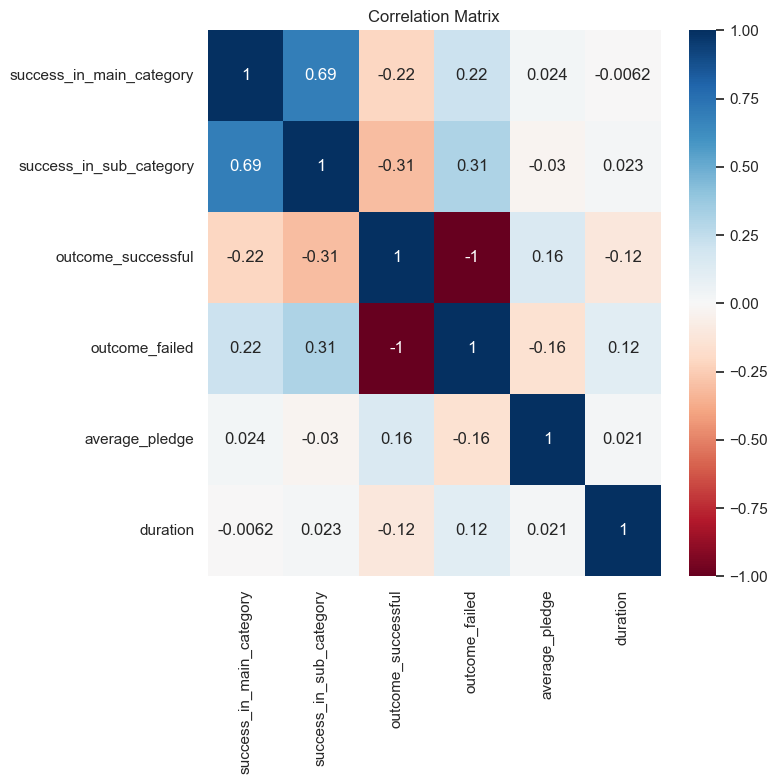

In [71]:
cols = ['success_in_main_category', 'success_in_sub_category', 'outcome_successful', 'outcome_failed', 'average_pledge', 'duration']

# Calculate correlation matrix and visualize with seaborn
correlation_matrix = df[cols].corr().round(6)
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.tight_layout()





Exercise 3: Information gain with numeric values
We can compute information gains for segmenting by numeric values as well. For that purpose, we
need to determine the “optimal cut-off”: the value that maximize information gain. We will do this for
the variable campaign duration you created (in column Q in “Data”).
To compute the optimal cut-off, go to sheet “Ex3” and compute:
- For the full sample, count the number of campaigns (column A), the number that are successful
(column B), the percentage that are successful (column C) and compute the Entropy (column D).
As this is independent of the cut-off, you only have to do this once in row 3.
- Now we need to split the sample by all potential cut-offs, that is by all observed durations (in
column E). We split the sample in ‘below-or-equal to cut-off’ (columns F to J) and ‘above cut-off’
(columns K to O).
- For the first segment, compute the number of campaigns below/equal to cut-off (column F), the
same as a fraction of all campaigns (column G), the number below/equal to cut-off that are
successful (column H), and the percentage that are successful (column I). Now calculate the
segment’s entropy (column J).
Page 3 of 13
Strategy Analytics Tutorial 2 © Martin C. Goossen / Peter Snoeren
Note: if the Entropy formula provides an error, this is because the number of observations in the
segment is 0 and entropy should therefore also be 0. You can use ‘=IFERROR()’ for that purpose.
- Compute the same variables for the second segment, that is the segment above the cut-off values
(column E) in columns K to O.
- In column P, compute the information gain for each of the cut-off values using the entropies
(columns D, J, and O) and fraction sizes (columns G and L) you computed before.

In [72]:
campaigns_total = len(df)
campaigns_successful = df['outcome_successful'].sum()
percentage_successful = campaigns_successful / campaigns_total
entropy = -percentage_successful * np.log2(percentage_successful) - (1-percentage_successful) * np.log2(1-percentage_successful)

descriptives = {
    'campaigns_total': campaigns_total,
    'campaigns_successful': campaigns_successful,
    'percentage_successful': percentage_successful,
    'entropy': entropy
    }

In [73]:
df_duration = df.groupby('duration').agg({'outcome_successful': ['count', 'sum']})

df_duration.columns = ['campaigns', 'successes']
df_duration.reset_index(inplace=True)

df_duration['prop_success'] = df_duration['successes'] / df_duration['campaigns']

df_duration['campaigns_cumsum'] = df_duration['campaigns'].cumsum()
df_duration['successes_cumsum'] = df_duration['successes'].cumsum()

df_duration['campaigns_above'] = descriptives['campaigns_total'] - df_duration['campaigns_cumsum']
df_duration['successes_above'] = descriptives['campaigns_successful'] - df_duration['successes_cumsum']

df_duration['prop_success_below'] = df_duration['successes_cumsum'] / df_duration['campaigns_cumsum']
df_duration['prop_success_above'] = df_duration['successes_above'] / df_duration['campaigns_above']

df_duration['entropy_below'] = (- (df_duration.prop_success_below * np.log2(df_duration.prop_success_below)
                                   + (1-df_duration.prop_success_below) * np.log2(1-df_duration.prop_success_below)))

df_duration['entropy_above'] = (- (df_duration.prop_success_above * np.log2(df_duration.prop_success_above)
                                   + (1-df_duration.prop_success_above) * np.log2(1-df_duration.prop_success_above)))


df_duration['info_gain'] = (descriptives['entropy'] - 
                                  (df_duration['campaigns_cumsum'] / descriptives['campaigns_total'] * df_duration['entropy_below'] + 
                                   df_duration['campaigns_above'] / descriptives['campaigns_total'] * df_duration['entropy_above']))



df_duration.loc[df_duration['info_gain'].idxmax()]


duration                  28.000000
campaigns               5515.000000
successes               2792.000000
prop_success               0.506256
campaigns_cumsum       62887.000000
successes_cumsum       33341.000000
campaigns_above       268578.000000
successes_above       100510.000000
prop_success_below         0.530173
prop_success_above         0.374230
entropy_below              0.997371
entropy_above              0.953865
info_gain                  0.011020
Name: 28, dtype: float64

Exercise 4: Logistic regression
Run a logistic regression predicting if a project is successful using the following variables: Duration,
Success in main category, and Success in sub-category.

In [74]:
ivs = ['duration', 'success_in_main_category', 'success_in_sub_category']
dv = 'outcome_successful'

df[ivs + [dv]].corr()

,duration,success_in_main_category,success_in_sub_category,outcome_successful
duration,1.000000,-0.006195,0.023095,-0.116459
success_in_main_category,-0.006195,1.000000,0.690542,-0.215725
success_in_sub_category,0.023095,0.690542,1.000000,-0.308530
outcome_successful,-0.116459,-0.215725,-0.308530,1.000000


In [88]:
X = df[['duration', 'success_in_main_category', 'success_in_sub_category']].copy()
X['success_in_main_category'] = 1 - X['success_in_main_category']
X['success_in_sub_category'] = 1 - X['success_in_sub_category']
X['constant'] = 1
y = df[dv]
model = sm.Logit(y, X).fit()
print(model.summary().as_text())

Optimization terminated successfully.
         Current function value: 0.618500
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     outcome_successful   No. Observations:               331465
Model:                          Logit   Df Residuals:                   331461
Method:                           MLE   Df Model:                            3
Date:                 wo, 19 feb 2025   Pseudo R-squ.:                 0.08306
Time:                        16:18:48   Log-Likelihood:            -2.0501e+05
converged:                       True   LL-Null:                   -2.2358e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
duration                    -0.0202      0.000    -65.204      0.000      -0.021

Exercise 5: Logistic probabilities
Run a logistic regression predicting project success using the following variables: Duration, Success in
main category, and Success in sub-category.
Sheet “Ex5” contains the details of three new campaigns: A, B, and C. We would like to compute the
chance that these will succeed using the formula from the logistic regression:

 P(P=Y) = e^(βX)/(1 + e^(βX)) = 1/(1 + e^(-βX))
 
 In order to do so, first copy the coefficients and constant from your regression to column F. Now
compute the probability of campaigns success using the above formula.
Hint: use =SUMPRODUCT() to simplify your calculations.

In [91]:
# Create dataframe from the campaign data
campaigns = pd.DataFrame({
    'duration': [60, 30, 90],
    'success_in_main_category': [0.4, 0.6, 0.5], 
    'success_in_sub_category': [0.6, 0.3, 0.4],
    'constant': [1, 1, 1]
})

campaigns


,duration,success_in_main_category,success_in_sub_category,constant
0,60,0.4,0.6,1
1,30,0.6,0.3,1
2,90,0.5,0.4,1


In [92]:
model.predict(campaigns)

0    0.472070
1    0.308265
2    0.169612
dtype: float64

In [113]:
predictions = (model.predict(X) > 0.5).astype(int)
accuracy = (predictions == y).mean()
print(f"Accuracy: {accuracy:.4f}")

# Create all-successful predictions (all 1s)
all_successful = pd.Series(1, index=y.index)

# Calculate accuracy
accuracy = (all_successful == y).mean()
print(f"Accuracy if predicting all successful: {accuracy:.3f}")

# Create all-successful predictions (all 1s)
all_successful = pd.Series(0, index=y.index)

# Calculate accuracy
accuracy = (all_successful == y).mean()
print(f"Accuracy if predicting all successful: {accuracy:.3f}")

Accuracy: 0.6580
Accuracy if predicting all successful: 0.404
Accuracy if predicting all successful: 0.596


# Part 2

In [114]:
df2 = pd.read_csv("./Data/Part 2 - Turnover.csv")

In [120]:
df2 = pd.concat([df2, pd.get_dummies(df2[['accident', 'left', 'promotion']], prefix=['accident', 'left', 'promotion']).astype(int)], axis=1)

In [133]:
df2_descriptives = df2.describe(include='all')

summary_stats = {
    'employees_left_rate': df2_descriptives.left_yes['mean'],
    'employees_left_count': df2.left_yes.value_counts()[1],
    'employees_total': len(df2)
}

summary_stats


{'employees_left_rate': np.float64(0.2393846153846154),
 'employees_left_count': np.int64(3112),
 'employees_total': 13000}

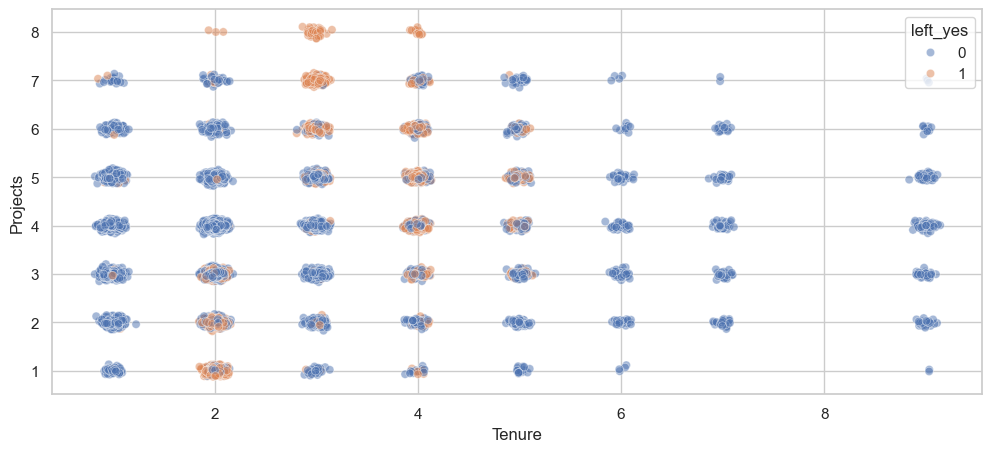

In [158]:
jittered_x = df2['tenure'] + np.random.normal(0, 0.05, size=len(df2))
jittered_y = df2['projects'] + np.random.normal(0, 0.05, size=len(df2))

sns.scatterplot(x=jittered_x, y=jittered_y, alpha=0.5, hue=df2.left_yes)
plt.xlabel('Tenure')
plt.ylabel('Projects')
plt.grid(True)
plt.show()